Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Aproximação de funções com redes neurais MLP

Implemente uma rede neural e utilize o treinamento com o algoritmo de retropropagação para modelar as seguintes funções:

a) $\displaystyle f(x) = \frac{1}{x},\;\; 1\le x \le 100$

b) $f(x) = {\rm log}_{10}x,\;\; 1\le x \le 10$

c) $f(x) = {\rm exp}(-x),\;\; 1\le x \le 10$

d) $\displaystyle f(x) = {\rm sen}(x),\;\; 0\le x \le \frac{\pi}{2}$

- Implemente uma rede neural com uma entrada, um número variável de neurônios na camada oculta e uma saída. Para tanto, uma sugestão é implementar duas funções:
  - *Treinamento*, que recebe o sinal de entrada, o passo de adaptação, o número de épocas e o número de neurônios da camada oculta e retorna os pesos da rede treinada e um sinal com o valor da função custo ao longo das épocas;
  - *Inferência*: que recebe os pesos da rede, o número de neurônios na camada oculta (também poderia obter essa informação a partir dos pesos) e uma entrada e retorna a saída da rede.
- Utilize uma função sigmoidal como função de ativação para os neurônios da camada oculta e da camada de saída (note que as funções sempre retornam valores entre 0 e 1 nos intervalos indicados);
- Faça a implementação **usando apenas vetores, tensores e operações aritméticas**, sem utilizar recursos de *frameworks* para redes neurais como Keras ou PyTorch;
- Crie dois conjuntos de dados, um deles para treinamento da rede e outro para o teste. Considere entre 1000 a 10000 pontos para treinamento e 1000 para teste;
- Avalie o desempenho da rede para cada caso, calculando o erro quadrático médio obtido no conjunto de teste e plotando gráficos da funções e das aproximações obtidas com a rede, considerando os seguintes números de neurônios na camada oculta: 3, 4, 5, 10, 15, 20, 50, 100.

## Resolução

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Funções auxiliares
# ===============================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)  # usando o valor já ativado

# ===============================
# Função de treinamento
# ===============================

def train_nn(X, Y, hidden_neurons=10, lr=0.01, epochs=10000):
    np.random.seed(42)
    n_input = X.shape[1]
    n_output = Y.shape[1]

    # Inicialização dos pesos
    W1 = np.random.randn(n_input, hidden_neurons)
    b1 = np.zeros((1, hidden_neurons))
    W2 = np.random.randn(hidden_neurons, n_output)
    b2 = np.zeros((1, n_output))

    mse_history = []

    for epoch in range(epochs):
        # FORWARD
        hidden_input = np.dot(X, W1) + b1
        hidden_output = sigmoid(hidden_input)
        output_input = np.dot(hidden_output, W2) + b2
        output = sigmoid(output_input)

        # Erro
        error = Y - output
        mse = np.mean(np.square(error))
        mse_history.append(mse)

        # BACKPROP
        d_output = error * sigmoid_deriv(output)
        d_hidden = np.dot(d_output, W2.T) * sigmoid_deriv(hidden_output)

        # Atualização dos pesos
        W2 += lr * np.dot(hidden_output.T, d_output)
        b2 += lr * np.sum(d_output, axis=0, keepdims=True)
        W1 += lr * np.dot(X.T, d_hidden)
        b1 += lr * np.sum(d_hidden, axis=0, keepdims=True)

    weights = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return weights, mse_history

# ===============================
# Função de inferência
# ===============================

def infer_nn(X, weights):
    W1, b1, W2, b2 = weights["W1"], weights["b1"], weights["W2"], weights["b2"]
    hidden_output = sigmoid(np.dot(X, W1) + b1)
    output = sigmoid(np.dot(hidden_output, W2) + b2)
    return output

# ===============================
# Função para normalizar valores
# ===============================

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# ===============================
# Avaliação e plotagem
# ===============================

def evaluate_function(f, x_range, hidden_sizes, train_points=5000, test_points=1000,
                      lr=0.01, epochs=5000, title='Função'):

    # Geração dos dados
    x_train = np.linspace(x_range[0], x_range[1], train_points).reshape(-1, 1)
    y_train = f(x_train)
    x_test = np.linspace(x_range[0], x_range[1], test_points).reshape(-1, 1)
    y_test = f(x_test)

    # Normaliza os valores entre 0 e 1 (importante para função sigmoide)
    y_train_norm = normalize(y_train)
    y_test_norm = normalize(y_test)
    x_train_norm = normalize(x_train)
    x_test_norm = normalize(x_test)

    mse_results = {}

    plt.figure(figsize=(15, 10))

    for i, h in enumerate(hidden_sizes):
        weights, mse_hist = train_nn(x_train_norm, y_train_norm, hidden_neurons=h,
                                     lr=lr, epochs=epochs)
        y_pred_norm = infer_nn(x_test_norm, weights)
        y_pred = y_pred_norm * (np.max(y_test) - np.min(y_test)) + np.min(y_test)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_results[h] = mse

        # Plot
        plt.subplot(3, 3, i + 1)
        plt.plot(x_test, y_test, label='Real', color='black')
        plt.plot(x_test, y_pred, label='Rede', linestyle='dashed')
        plt.title(f"{title} - {h} neurônios\nMSE={mse:.6f}")
        plt.legend()
        plt.tight_layout()

    plt.show()
    return mse_results


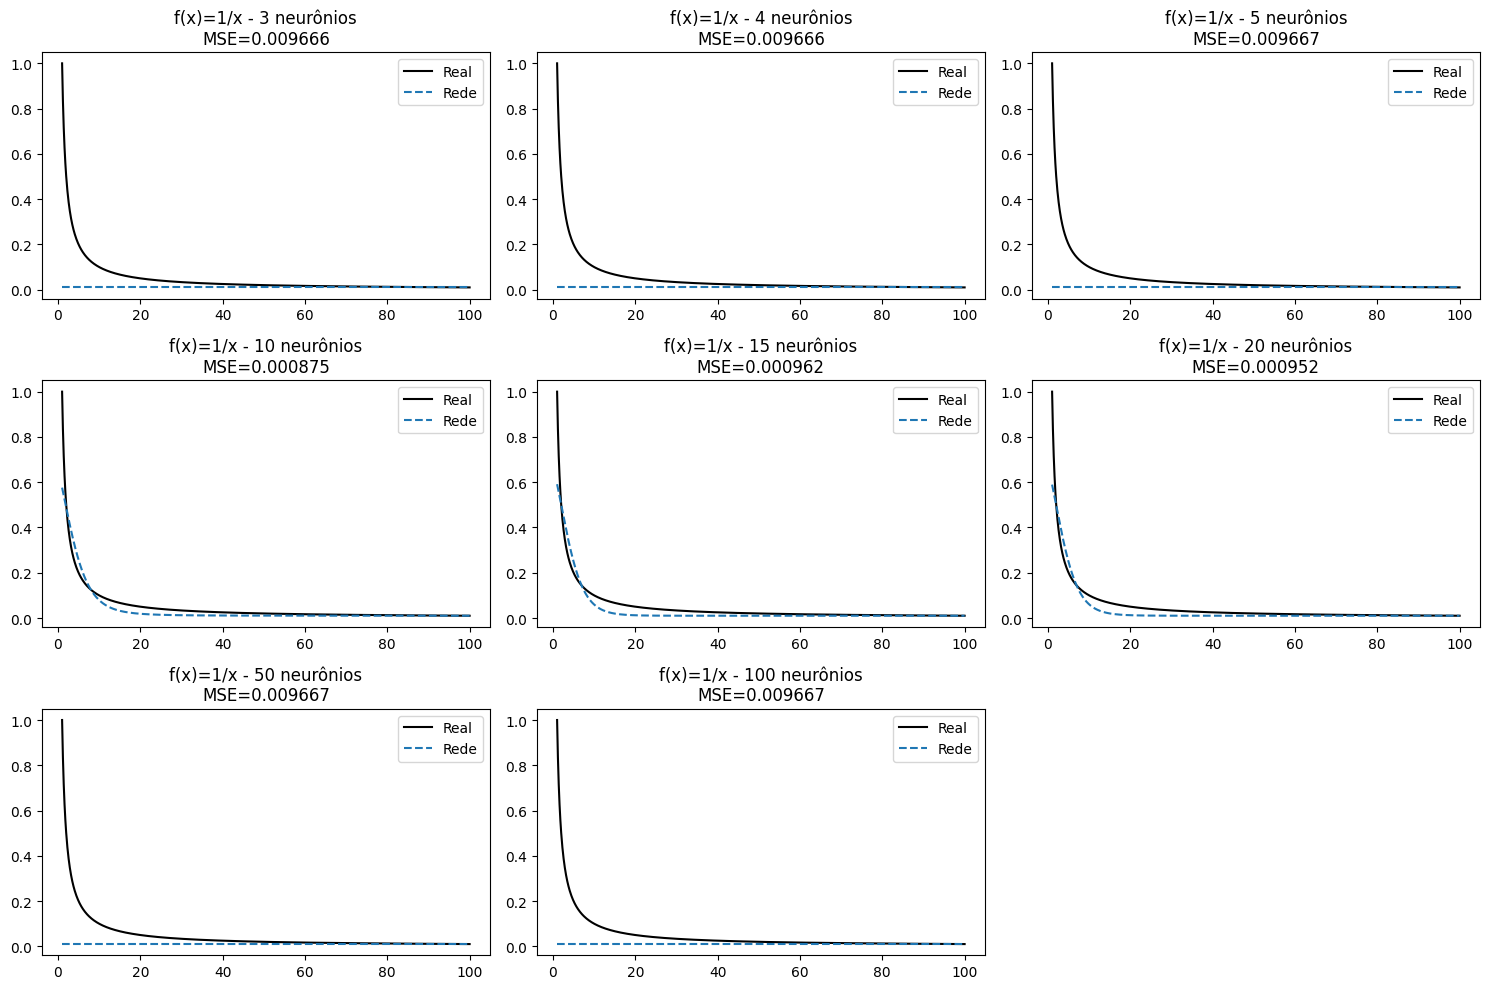

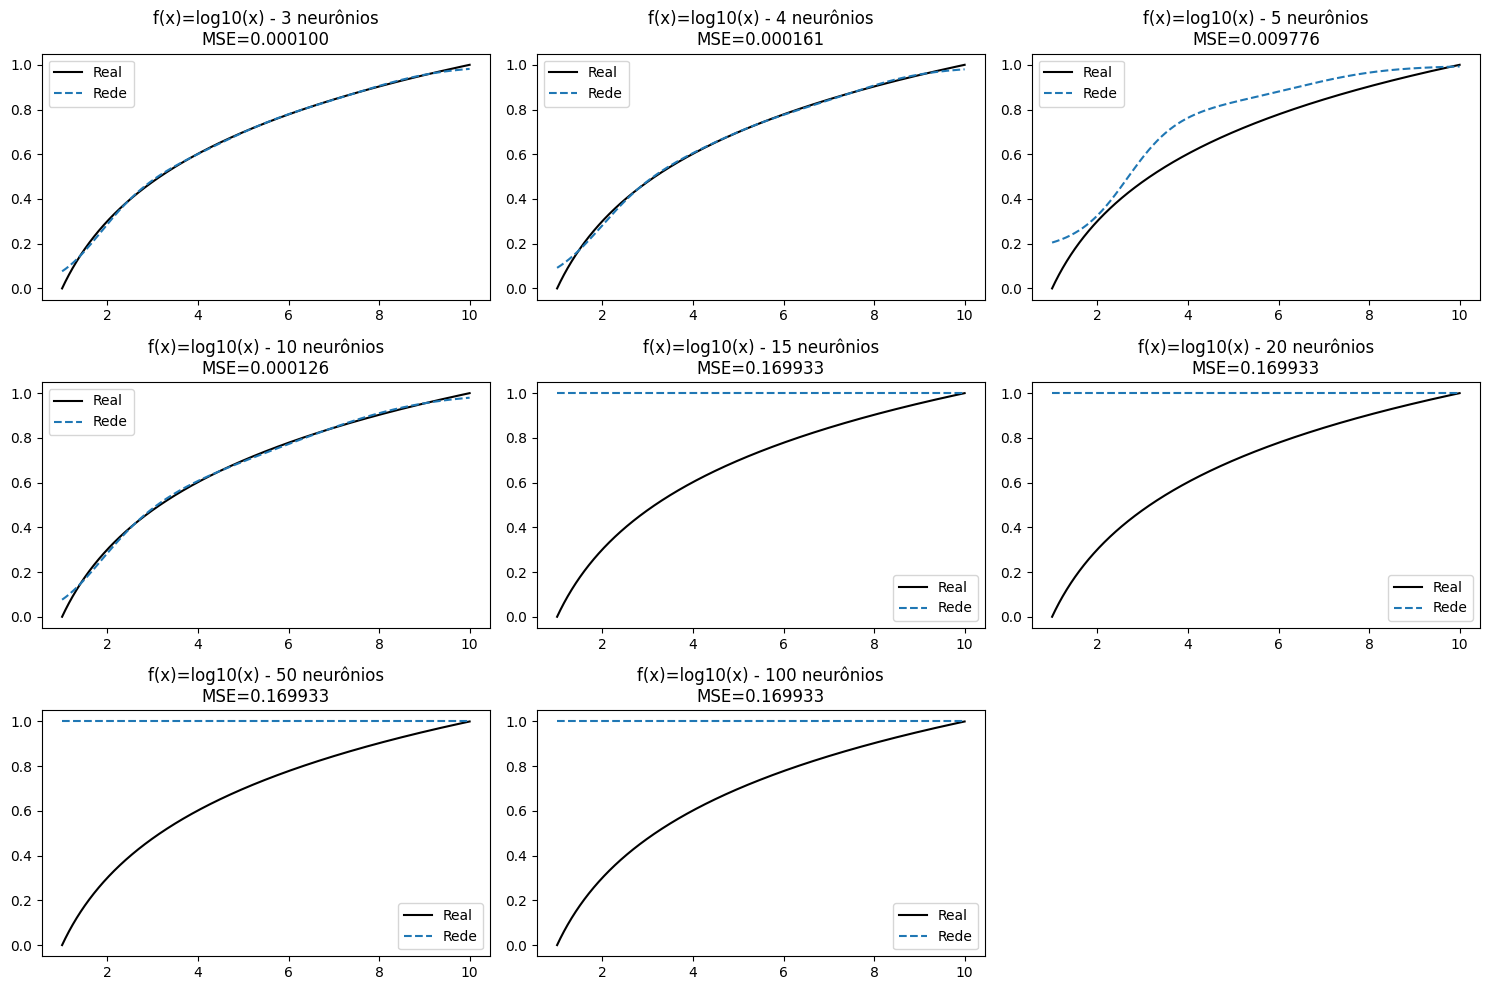

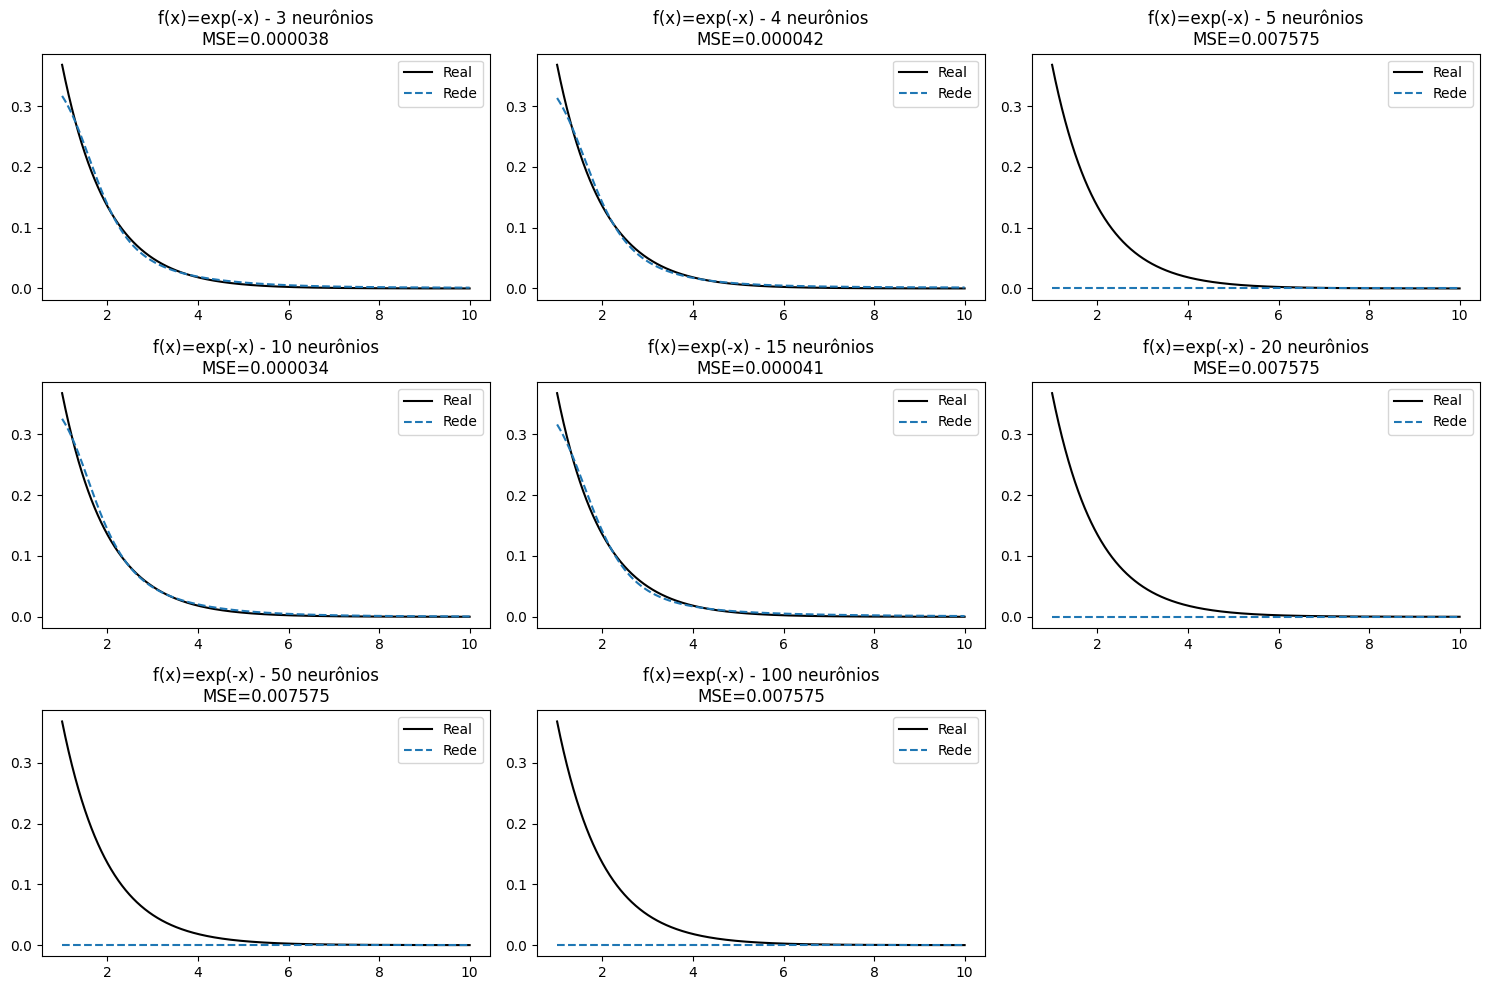

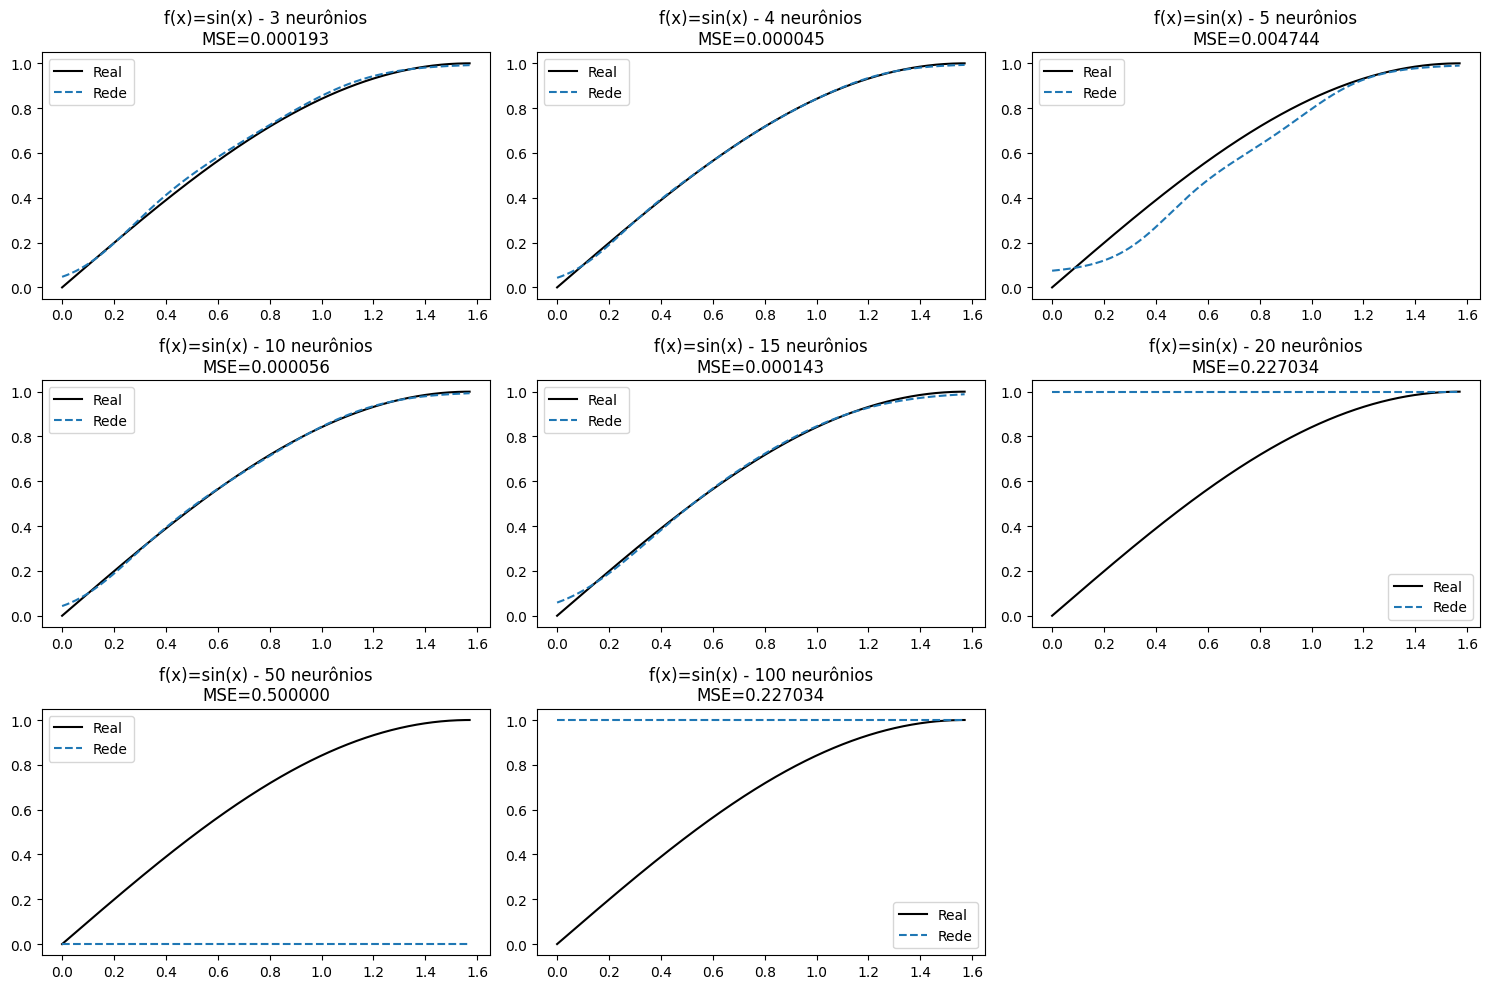

In [5]:
# a) f(x) = 1/x, 1 ≤ x ≤ 100
mse_a = evaluate_function(lambda x: 1/x, (1, 100),
                          hidden_sizes=[3,4,5,10,15,20,50,100],
                          title='f(x)=1/x')

# b) f(x) = log10(x), 1 ≤ x ≤ 10
mse_b = evaluate_function(lambda x: np.log10(x), (1, 10),
                          hidden_sizes=[3,4,5,10,15,20,50,100],
                          title='f(x)=log10(x)')

# c) f(x) = exp(-x), 1 ≤ x ≤ 10
mse_c = evaluate_function(lambda x: np.exp(-x), (1, 10),
                          hidden_sizes=[3,4,5,10,15,20,50,100],
                          title='f(x)=exp(-x)')

# d) f(x) = sin(x), 0 ≤ x ≤ π/2
mse_d = evaluate_function(lambda x: np.sin(x), (0, np.pi/2),
                          hidden_sizes=[3,4,5,10,15,20,50,100],
                          title='f(x)=sin(x)')
